In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip uninstall xgboost -y
!pip install -U xgboost

!pip uninstall scikit-learn -y
!pip install -U scikit-learn

Found existing installation: xgboost 0.90
Uninstalling xgboost-0.90:
  Successfully uninstalled xgboost-0.90
     |████████████████████████████████| 173.5 MB 56 kB/s 
Found existing installation: scikit-learn 0.22.2.post1
Uninstalling scikit-learn-0.22.2.post1:
  Successfully uninstalled scikit-learn-0.22.2.post1
     |████████████████████████████████| 23.2 MB 1.6 MB/s 


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import matplotlib.gridspec as gridspec
import seaborn as sns

from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import brier_score_loss
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
import warnings
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
import xgboost as xgb
import joblib
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
import os

In [ ]:
basedir = '/content/drive/MyDrive/recidivism/'
raw_datadir = os.path.join(basedir,'data','01_raw')
interim_datadir = os.path.join(basedir,'data','02_interim')
processed_datadir = os.path.join(basedir,'data','03_processed')
modelsdir = os.path.join(basedir,'models')

In [ ]:
xtrain_path = os.path.join(processed_datadir, "Xtrain.csv")
xtest_path = os.path.join(processed_datadir, "Xtest.csv")
ytrain_path = os.path.join(processed_datadir, "ytrain.csv")
ytest_path = os.path.join(processed_datadir, "ytest.csv")

X_train = pd.read_csv(xtrain_path)
X_test = pd.read_csv(xtest_path)
y_train = pd.read_csv(ytrain_path, squeeze=True)
y_test = pd.read_csv(ytest_path, squeeze=True)

print("X_train:",X_train.shape)
print("X_test:",X_test.shape)
print("y_train:",y_train.shape)
print("y_test:",y_test.shape)

X_train: (19920, 42)
X_test: (4980, 42)
y_train: (19920,)
y_test: (4980,)


In [ ]:
columns = ['Age_at_Release',
'Education_Level',
'Dependents',
'Prison_Years',
'Prior_Arrest_Episodes_Felony',
'Prior_Arrest_Episodes_Misd',
'Prior_Arrest_Episodes_Violent',
'Prior_Arrest_Episodes_Property',
'Prior_Arrest_Episodes_Drug',
'Prior_Arrest_Episodes_PPViolationCharges',
'Prior_Conviction_Episodes_Felony',
'Prior_Conviction_Episodes_Misd',
'Prior_Conviction_Episodes_Prop',
'Prior_Conviction_Episodes_Drug',
'Delinquency_Reports',
'Program_Attendances',
'Program_UnexcusedAbsences',
'Residence_Changes',
'Drug_Test_Results',
'Percent_Days_Employed']
result = pd.Series({c: X_train[columns][c].unique() for c in X_train[columns]})
print(result)

Age_at_Release                              [28-32, 38-42, 43-47, 33-37, 23-27, 48 or olde...
Education_Level                             [Less than HS diploma, At least some college, ...
Dependents                                                               [2, 3 or more, 1, 0]
Prison_Years                                [More than 3 years, Less than 1 year, 1-2 year...
Prior_Arrest_Episodes_Felony                       [6, 2, 5, 4, 10 or more, 3, 9, 1, 7, 8, 0]
Prior_Arrest_Episodes_Misd                                      [3, 6 or more, 1, 0, 4, 2, 5]
Prior_Arrest_Episodes_Violent                                            [1, 0, 2, 3 or more]
Prior_Arrest_Episodes_Property                                     [1, 2, 3, 0, 5 or more, 4]
Prior_Arrest_Episodes_Drug                                         [4, 1, 2, 0, 3, 5 or more]
Prior_Arrest_Episodes_PPViolationCharges                           [3, 5 or more, 1, 0, 2, 4]
Prior_Conviction_Episodes_Felony                            

In [ ]:
class GroupImputer(BaseEstimator, TransformerMixin):
    '''
    Class used for imputing missing values in a pd.DataFrame using either mean or median of a group.
    
    Parameters
    ----------    
    group_cols : list
        List of columns used for calculating the aggregated value 
    target : str
        The name of the column to impute
    metric : str
        The metric to be used for remplacement, can be one of ['mean', 'median']

    Returns
    -------
    X : array-like
        The array with imputed values in the target column
    '''
    def __init__(self, group_cols, target, metric='mean'):
        
        assert metric in ['mean', 'median'], 'Unrecognized value for metric, should be mean/median'
        assert type(group_cols) == list, 'group_cols should be a list of columns'
        assert type(target) == str, 'target should be a string'
        
        self.group_cols = group_cols
        self.target = target
        self.metric = metric
    
    def fit(self, X, y=None):
        
        assert pd.isnull(X[self.group_cols]).any(axis=None) == False, 'There are missing values in group_cols'
        
        impute_map = X.groupby(self.group_cols)[self.target].agg(self.metric) \
                                                            .reset_index(drop=False)
        
        self.impute_map_ = impute_map
        
        return self 
    
    def transform(self, X, y=None):
        
        # make sure that the imputer was fitted
        check_is_fitted(self, 'impute_map_')
        
        X = X.copy()
        
        for index, row in self.impute_map_.iterrows():
            ind = (X[self.group_cols] == row[self.group_cols]).all(axis=1)
            X.loc[ind, self.target] = X.loc[ind, self.target].fillna(row[self.target])
        
        return X.values



## Create imputers
* imputer Avg_Days_per_DrugTest based upon column mean

In [ ]:

simpleImputer = SimpleImputer()

## Create Encoders

### One Hot Encoder

In [ ]:
oneHot = OneHotEncoder(drop='if_binary')



### Ordinal Encoder

#### Define order for categories and create encoder

In [ ]:
ageList = ['18-22','23-27','28-32','33-37','38-42','43-47','48 or older']
education = ['Less than HS diploma','High School Diploma', 'At least some college']
dependents = ['0', '1', '2', '3 or more']
prisonYears = ['Less than 1 year', '1-2 years', 'Greater than 2 to 3 years','More than 3 years']
felony = ['0', '1', '2', '3', '4','5', '6', '7', '8', '9', '10 or more']
misd = ['0','1','2','3','4','5','6 or more']
violent = ['0','1','2', '3 or more']
prop = ['0','1','2','3','4','5 or more']
drug = ['0','1','2','3','4','5 or more']
ppviolation = ['0','1','2','3','4','5 or more']
felony2 = ['0', '1', '2', '3 or more']
misd2 = ['0','1', '2', '3', '4 or more']
prop2 = ['0', '1', '2', '3 or more']
drug2 = ['0','1', '2 or more']
delinquency = ['0' ,'1', '2','3', '4 or more']
attendances = ['0','1','2','3','4','5', '6','7','8','9', '10 or more']
unexcused = ['0', '1', '2', '3 or more']
residence = ['0','1','2', '3 or more']
employment = ['None', 'Less Than Half', 'More Than Half', 'All']
 
ordinalEnc = OrdinalEncoder(categories=[ageList,education,dependents,
                                        prisonYears,felony,misd,violent,prop,drug,
                                        ppviolation,felony2,misd2,prop2,drug2,
                                        delinquency,attendances,unexcused,
                                        residence,employment])

In [ ]:
ordlist = ['Age_at_Release','Education_Level',
'Dependents','Prison_Years','Prior_Arrest_Episodes_Felony',
'Prior_Arrest_Episodes_Misd','Prior_Arrest_Episodes_Violent',
'Prior_Arrest_Episodes_Property','Prior_Arrest_Episodes_Drug',
'Prior_Arrest_Episodes_PPViolationCharges','Prior_Conviction_Episodes_Felony',
'Prior_Conviction_Episodes_Misd','Prior_Conviction_Episodes_Prop',
'Prior_Conviction_Episodes_Drug','Delinquency_Reports',
'Program_Attendances','Program_UnexcusedAbsences',
'Residence_Changes','Percent_Days_Employed']

onehotlist = ['Gender','Race','Residence_PUMA','Gang_Affiliated',
'Supervision_Level_First','Prison_Offense','Prior_Arrest_Episodes_DVCharges',
'Prior_Arrest_Episodes_GunCharges','Prior_Conviction_Episodes_Viol',
'Prior_Conviction_Episodes_PPViolationCharges','Prior_Conviction_Episodes_DomesticViolenceCharges',
'Prior_Conviction_Episodes_GunCharges','Prior_Revocations_Parole',
'Prior_Revocations_Probation','Condition_MH_SA','Condition_Cog_Ed',
'Condition_Other','Violations_Instruction',
'Violations_FailToReport','Violations_MoveWithoutPermission',
'Employment_Exempt','Drug_Test_Results','Age_at_Release','Education_Level',
'Dependents','Prison_Years','Prior_Arrest_Episodes_Felony',
'Prior_Arrest_Episodes_Misd','Prior_Arrest_Episodes_Violent',
'Prior_Arrest_Episodes_Property','Prior_Arrest_Episodes_Drug',
'Prior_Arrest_Episodes_PPViolationCharges','Prior_Conviction_Episodes_Felony',
'Prior_Conviction_Episodes_Misd','Prior_Conviction_Episodes_Prop',
'Prior_Conviction_Episodes_Drug','Delinquency_Reports',
'Program_Attendances','Program_UnexcusedAbsences',
'Residence_Changes','Percent_Days_Employed']

scalerlist = ['Supervision_Risk_Score_First']

## Define Standard Scaler

In [ ]:
scaler = StandardScaler()

## Define Column Transformer for use in models

In [ ]:


ct = ColumnTransformer([('oneHot',oneHot,onehotlist),
                        ('scaler', scaler, ['Supervision_Risk_Score_First'])
                        ], 
                       remainder='passthrough')

ct2 = ColumnTransformer([
                        ('scaler', scaler, ['Supervision_Risk_Score_First'])
                        ], 
                       remainder='passthrough')

# Model Building

## Define function to calculate scores and produce ROC curve
## Define common variables for use in all models

In [ ]:
def calc_scores(model,X_test,y_test,estimator_name):
    proba = model.predict_proba(X_test)
    preds = model.predict(X_test)
    pos_proba = proba[:,1]
    bs = brier_score_loss(y_test, pos_proba)
    f1 = f1_score(y_test,preds)
    rs = recall_score(y_test,preds)
    ps = precision_score(y_test,preds)
    roc = roc_auc_score(y_test, pos_proba)
    fpr, tpr, thresholds = roc_curve(y_test,preds)
    # display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc,estimator_name=estimator_name)
    display = RocCurveDisplay.from_predictions(y_test, pos_proba,name=estimator_name)
    scores = [bs, f1, rs, ps, roc]
    return scores, display

tests = ['Brier Score', 'F1 Score', 'Recall', 'Precision', 'ROC_AUC']
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=3)
cv = StratifiedKFold(n_splits=10)

## K-Nearest Neighbors

In [ ]:
knn_model = KNeighborsClassifier()

knn_pipeline = Pipeline([("columnTransformer",ct),("knn", knn_model)])


In [ ]:
knn_params = {'knn__n_neighbors':[5,10,15,20], 'knn__metric':['minkowski', 'chebyshev']}


In [ ]:
knn_cv = GridSearchCV(knn_pipeline, knn_params, scoring='roc_auc', n_jobs=-1, cv=cv)

In [ ]:
knn_cv.fit(X_train,y_train)
joblib.dump(knn_cv.best_estimator_, os.path.join(modelsdir,"model_knn_auc_oh_best.pkl"))
joblib.dump(knn_cv, os.path.join(modelsdir,"model_knn_auc_oh.pkl"))

['/content/drive/MyDrive/recidivism/models/model_knn_auc.pkl']

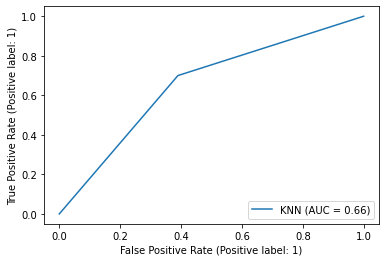

In [ ]:
knn_scores, knn_display = calc_scores(knn_cv, X_test, y_test, 'KNN')


In [ ]:
print(pd.DataFrame(knn_scores, index=tests, columns=['KNN']))


                  KNN
Brier Score  0.209045
F1 Score     0.727123
Recall       0.756507
Precision    0.699937
ROC_AUC      0.648399


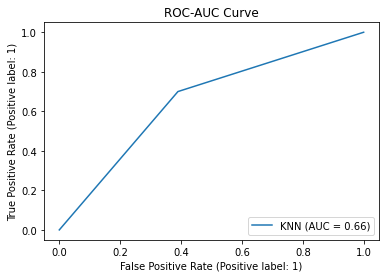

In [ ]:
fig, ax = plt.subplots()
knn_display.plot(ax=ax)
ax.set_title("ROC-AUC Curve")
plt.show()

## Logistic Regression with Elastic Net Regularization

In [ ]:
lr_model = LogisticRegression()

lr_params = {'lr__warm_start': [True, False],'lr__penalty':['elasticnet'],'lr__C':[0.01, 0.05, 0.1, 0.15,0.25, 0.5, 1.0],'lr__solver':['saga'], 'lr__max_iter':[5000], 'lr__l1_ratio':np.linspace(0,1,20,True)}

lr_pipeline = Pipeline([("columnTransformer",ct),("lr", lr_model)])


In [ ]:
lr_cv = GridSearchCV(lr_pipeline, lr_params, scoring='roc_auc', n_jobs=-1,cv=cv)
lr_cv.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('columnTransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinal',
                                                                         OrdinalEncoder(categories=[['18-22',
                                                                                                     '23-27',
                                                                                                     '28-32',
                                                                                                     '33-37',
                                                                                                     '38-42',
                                                                                                     '43-47',
                                

In [ ]:
joblib.dump(lr_cv.best_estimator_, os.path.join(modelsdir,'model_lr_auc_oh_best.pkl'))
joblib.dump(lr_cv, os.path.join(modelsdir,'model_lr_auc_oh.pkl'))

['/content/drive/MyDrive/recidivism/models/model_lr_auc.pkl']

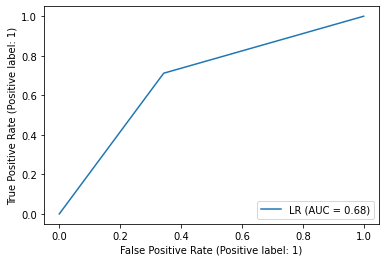

In [ ]:
lr_scores, lr_display = calc_scores(lr_cv, X_test, y_test, 'LR')

In [ ]:
pd.DataFrame(lr_scores, index=tests, columns=['Logistic Regression'])

,Logistic Regression
Brier Score,0.198255
F1 Score,0.753787
Recall,0.801027
Precision,0.711808
ROC_AUC,0.670659


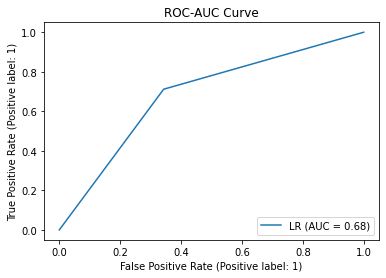

In [ ]:
fig, ax = plt.subplots()
lr_display.plot(ax=ax)
ax.set_title("ROC-AUC Curve")
plt.show()

In [ ]:
lr_cv.best_params_

{'lr__C': 0.1,
 'lr__l1_ratio': 0.7368421052631579,
 'lr__max_iter': 5000,
 'lr__penalty': 'elasticnet',
 'lr__solver': 'saga',
 'lr__warm_start': False}

In [ ]:
lr_cv.best_estimator_['lr'].coef_

array([[-0.25213042,  0.03662572,  0.        , -0.11739556,  0.06050594,
         0.04271276,  0.04919888,  0.06266617,  0.00602859,  0.09721401,
         0.05735895,  0.07192769,  0.00914726, -0.03618659, -0.13784734,
        -0.04018501,  0.0831649 ,  0.13890388, -0.35917667,  0.24501005,
         0.10124621,  0.        , -0.16747785, -0.01831457, -0.04255285,
        -0.10847461, -0.19379268,  0.        , -0.1921356 ,  0.        ,
         0.17770196,  0.        ,  0.        ,  0.        ,  0.02664465,
         0.09648056,  0.        ,  0.15625897,  0.        , -0.1534317 ,
         0.11471921,  0.        ,  0.21500519,  0.        ,  0.        ,
         0.04413079,  0.        ,  0.78779855, -0.22481944,  0.        ,
         0.00336998, -0.22287585,  0.        , -0.08532908,  0.        ,
         0.04360941,  0.00179712,  0.01785467, -0.15173674,  0.        ,
        -0.02406503,  0.        , -0.11949099,  0.02544619,  0.02439989,
         0.298313  , -0.09163371,  0.34904206, -0.0

## Decision Tree

In [ ]:
dt_model = DecisionTreeClassifier()
dt_params = {'dt__criterion':['gini', 'entropy'], 'dt__splitter':['best', 'random']}
dt_pipeline = Pipeline([('columnTransformer', ct),('dt', dt_model)])



In [ ]:
dt_cv = GridSearchCV(dt_pipeline, dt_params, scoring='roc_auc', n_jobs=-1, cv=cv)
dt_cv.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('columnTransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinal',
                                                                         OrdinalEncoder(categories=[['18-22',
                                                                                                     '23-27',
                                                                                                     '28-32',
                                                                                                     '33-37',
                                                                                                     '38-42',
                                                                                                     '43-47',
                                

In [ ]:
joblib.dump(dt_cv.best_estimator_, os.path.join(modelsdir,'model_dt_auc_oh_best.pkl'))
joblib.dump(dt_cv, os.path.join(modelsdir,'model_dt_auc_oh.pkl'))

['/content/drive/MyDrive/recidivism/models/model_dt_auc.pkl']

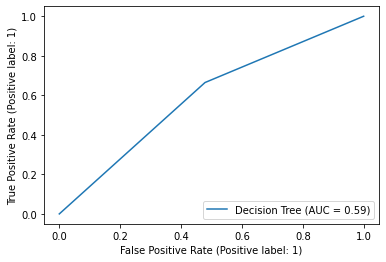

In [ ]:
dt_scores, dt_display = calc_scores(dt_cv, X_test, y_test, 'Decision Tree')

In [ ]:
pd.DataFrame(dt_scores, index=tests, columns=['Decision Tree'])

,Decision Tree
Brier Score,0.395783
F1 Score,0.660231
Recall,0.655822
Precision,0.664700
ROC_AUC,0.593445


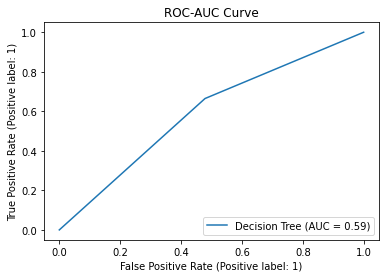

In [ ]:
fig, ax = plt.subplots()
dt_display.plot(ax=ax)
ax.set_title("ROC-AUC Curve")
plt.show()

## Random Forest

In [ ]:
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_params = {'rf__criterion':['gini', 'entropy'], 'rf__max_depth':[5,10,15,25,50]}
rf_pipeline = Pipeline([('columnTransformer', ct),('rf', rf_model)])



In [ ]:
rf_cv = GridSearchCV(rf_pipeline, rf_params, scoring='roc_auc', cv=cv)
rf_cv.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('columnTransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinal',
                                                                         OrdinalEncoder(categories=[['18-22',
                                                                                                     '23-27',
                                                                                                     '28-32',
                                                                                                     '33-37',
                                                                                                     '38-42',
                                                                                                     '43-47',
                                

In [ ]:
joblib.dump(rf_cv.best_estimator_, os.path.join(modelsdir,"model_rf_auc_oh_best.pkl"))
joblib.dump(rf_cv, os.path.join(modelsdir,"model_rf_auc_oh.pkl"))

['/content/drive/MyDrive/recidivism/models/model_rf_auc.pkl']

,Random Forest
Brier Score,0.195874
F1 Score,0.765405
Recall,0.838014
Precision,0.704375
ROC_AUC,0.669735


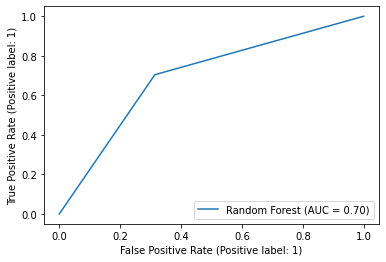

In [ ]:
rf_scores, rf_display = calc_scores(rf_cv, X_test, y_test, 'Random Forest')
pd.DataFrame(rf_scores, index=tests, columns=['Random Forest'])

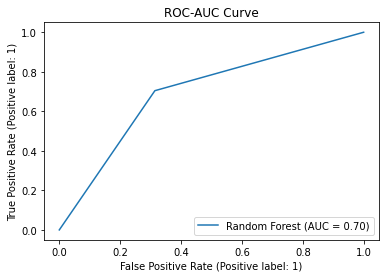

In [ ]:
fig, ax = plt.subplots()
rf_display.plot(ax=ax)
ax.set_title("ROC-AUC Curve")
plt.show()

In [ ]:
rf_cv.best_estimator_

Pipeline(steps=[('columnTransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal',
                                                  OrdinalEncoder(categories=[['18-22',
                                                                              '23-27',
                                                                              '28-32',
                                                                              '33-37',
                                                                              '38-42',
                                                                              '43-47',
                                                                              '48 '
                                                                              'or '
                                                                              'older'],
                                                               

## SGD Classifier

In [ ]:
sgd_model = SGDClassifier(random_state=42)
sgd_params = {'sgd__loss':['modified_huber','log'], 'sgd__penalty':['elasticnet'], 
              'sgd__alpha':[0.0001,0.001, 0.01, 0.1, 1,10,100], 'sgd__l1_ratio':np.linspace(0,1,10,True)}
sgd_pipeline = Pipeline([('columnTransformer', ct),('sgd', sgd_model)])



In [ ]:
sgd_cv = GridSearchCV(sgd_pipeline, sgd_params, scoring='roc_auc', cv=cv)
sgd_cv.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('columnTransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinal',
                                                                         OrdinalEncoder(categories=[['18-22',
                                                                                                     '23-27',
                                                                                                     '28-32',
                                                                                                     '33-37',
                                                                                                     '38-42',
                                                                                                     '43-47',
                                

In [ ]:
joblib.dump(sgd_cv.best_estimator_, os.path.join(modelsdir,'model_sgd_auc_oh_best.pkl'))
joblib.dump(sgd_cv, os.path.join(modelsdir,'model_sgd_auc_oh.pkl'))

['/content/drive/MyDrive/recidivism/models/model_sgd_auc.pkl']

,SGD
Brier Score,0.198282
F1 Score,0.752395
Recall,0.793493
Precision,0.715344
ROC_AUC,0.672960


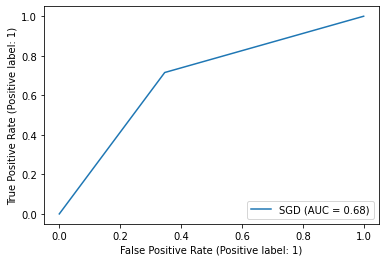

In [ ]:
sgd_scores, sgd_display = calc_scores(sgd_cv, X_test, y_test, 'SGD')
pd.DataFrame(sgd_scores, index=tests, columns=['SGD'])

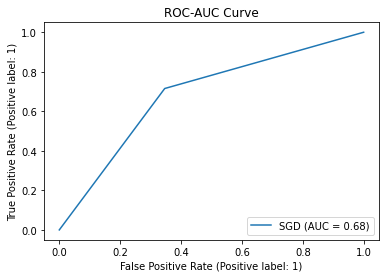

In [ ]:
fig, ax = plt.subplots()
sgd_display.plot(ax=ax)
ax.set_title("ROC-AUC Curve")
plt.show()

In [ ]:
sgd_cv.best_params_

{'sgd__alpha': 0.01,
 'sgd__l1_ratio': 0.0,
 'sgd__loss': 'log',
 'sgd__penalty': 'elasticnet'}

## XGBoost Model


In [ ]:
xgb_params = {
    'xgb__n_estimators':[1000],
    'xgb__booster': ['gbtree'],
    'xgb__eta': [.0001, .001, .01, .1], 
    'xgb__max_depth': [3, 6, 8],  
    'xgb__objective': ['binary:logistic'],  
    'xgb__subsample': [0.5, 0.75],
    'xgb__tree_method': ['approx', 'hist'],
    'xgb__eval_metric':['auc'], 
    'xgb__min_child_weight': [1, 5],
    'xgb__max_delta_step': [1, 5],
    'xgb__random_state': [42]} 

xgb_params_old = {
    'xgb__booster': ['gbtree'],
    'xgb__eta': [.0001, .0005, .001, .005, .01, .05, .1], 
    'xgb__max_depth': [3, 6, 8, 10],  
    'xgb__objective': ['multi:softprob'],  
    'xgb__num_class': [2],
    'xgb__subsample': [0.5, 0.75, 1],
    'xgb__tree_method': ['auto', 'hist'],
    'xgb__eval_metric':['merror'], 
    'xgb__min_child_weights': [1, 5, 10],
    'xgb__max_delta_step': [1, 5, 10]} 



xgb_model = xgb.XGBClassifier(use_label_encoder=False)
xgb_pipeline = Pipeline([('columnTransformer', ct),('xgb', xgb_model)])
xgb_cv = GridSearchCV(xgb_pipeline, xgb_params, scoring='roc_auc', cv=cv)



NameError: ignored

In [ ]:
xtrain_xgb_path = os.path.join(processed_datadir, "Xtrain_xgb.csv")
xval_xgb_path = os.path.join(processed_datadir, "Xval_xgb.csv")
ytrain_xgb_path = os.path.join(processed_datadir, "ytrain_xgb.csv")
yval_xgb_path = os.path.join(processed_datadir, "yval_xgb.csv")

X_train_xgb = pd.read_csv(xtrain__xgb_path)
X_val_xgb = pd.read_csv(xval_xgb_path)
y_train_xgb = pd.read_csv(ytrain_xgb_path, squeeze=True)
y_val_xgb = pd.read_csv(yval_xgb_path, squeeze=True)


ct.fit(X_train_xgb)
xgb_val_x = ct.transform(X_val_xgb)

In [ ]:
xgb_cv.fit(X_train_xgb,y_train_xgb, xgb__eval_set=[(xgb_val_x, y_val_xgb)], xgb__early_stopping_rounds =50 )

In [ ]:
joblib.dump(xgb_cv.best_estimator_, os.path.join(modelsdir,'model_xgb_auc_oh_best.pkl'))
joblib.dump(xgb_cv, os.path.join(modelsdir,'model_xgb_auc_oh.pkl'))
